In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from data.dataset import TUDatasetInterface, BarabasiAlbertDataset, ErdosRenyiDataset
import json
import os
import os.path as osp
from model.dgn.gmdn import GMDN
from experiment.experiment import Experiment
from experiment.util import s2c
from torch.distributions import Binomial, Independent, Categorical, MixtureSameFamily

Using backend: pytorch


In [2]:
data_root = 'DATA/ERDOS_RENYI'
size = 100
dataset_name = 'erdos_renyi_100_0.01@0.05@0.1@0.2'
dataset_class = 'data.dataset.ErdosRenyiDataset'
d = ErdosRenyiDataset(data_root, 'erdos_renyi', size, '0.01@0.05@0.1@0.2')
len(d)

120000

In [3]:
mdn_config_path = f'RESULTS/MDN/GMDN_{dataset_name}_SupervisedTask/MODEL_ASSESSMENT/OUTER_FOLD_1/MODEL_SELECTION/winner_config.json' 
mdn_ckpt_path = f'RESULTS/MDN/GMDN_{dataset_name}_SupervisedTask/MODEL_ASSESSMENT/OUTER_FOLD_1/final_run1/best_checkpoint.pth'
dgn_config_path = f'RESULTS/DGN/GMDN_{dataset_name}_SupervisedTask/MODEL_ASSESSMENT/OUTER_FOLD_1/MODEL_SELECTION/winner_config.json' 
dgn_ckpt_path = f'RESULTS/DGN/GMDN_{dataset_name}_SupervisedTask/MODEL_ASSESSMENT/OUTER_FOLD_1/final_run1/best_checkpoint.pth'
gmdn_config_path = f'RESULTS/GMDN/GMDN_{dataset_name}_SupervisedTask/MODEL_ASSESSMENT/OUTER_FOLD_1/MODEL_SELECTION/winner_config.json' 
gmdn_ckpt_path = f'RESULTS/GMDN/GMDN_{dataset_name}_SupervisedTask/MODEL_ASSESSMENT/OUTER_FOLD_1/final_run1/best_checkpoint.pth'
mdn_config = json.load(open(mdn_config_path, 'r'))['config']
mdn_ckpt = torch.load(mdn_ckpt_path)['model_state']
dgn_config = json.load(open(dgn_config_path, 'r'))['config']
dgn_ckpt = torch.load(dgn_ckpt_path)['model_state']
gmdn_config = json.load(open(gmdn_config_path, 'r'))['config']
gmdn_ckpt = torch.load(gmdn_ckpt_path)['model_state']

In [4]:
mdn_exp = Experiment(mdn_config, f'OUTPUTS/MDN_TESTS_{dataset_name}')
dgn_exp = Experiment(dgn_config, f'OUTPUTS/DGN_TESTS_{dataset_name}')
gmdn_exp = Experiment(gmdn_config, f'OUTPUTS/GMDN_TESTS_{dataset_name}')

In [5]:
batch_size = 1024
shuffle = False
device = 'cuda:0'
dataset_getter_class = s2c('pydgn.data.provider.DataProvider')
dataset_getter = dataset_getter_class(data_root,
                                      'SPLITS',
                                      'SPLITS/erdos_renyi_100_0.01@0.05@0.1@0.2/erdos_renyi_100_0.01@0.05@0.1@0.2_outer1_inner1.splits',
                                      s2c(dataset_class),
                                      dataset_name,
                                      1, # outer_folds
                                      1, # inner folds
                                      2, # num_workers
                                      True)  # pin memory
dataset_getter.set_outer_k(0)
dataset_getter.set_inner_k(0)

# Instantiate the Dataset Loaders
dim_node_features = dataset_getter.get_dim_node_features()
dim_edge_features = dataset_getter.get_dim_edge_features()
dim_target = dataset_getter.get_dim_target()
train_loader = dataset_getter.get_outer_train(batch_size=batch_size, shuffle=shuffle)
val_loader = dataset_getter.get_outer_val(batch_size=batch_size, shuffle=shuffle)
test_loader = dataset_getter.get_outer_test(batch_size=batch_size, shuffle=shuffle)

In [6]:
# Instantiate the Model
mdn_model = mdn_exp.create_supervised_model(dim_node_features, dim_edge_features, dim_target)
mdn_model.load_state_dict(mdn_ckpt)
mdn_model.to(device)
dgn_model = dgn_exp.create_supervised_model(dim_node_features, dim_edge_features, dim_target)
dgn_model.load_state_dict(dgn_ckpt)
dgn_model.to(device)
gmdn_model = gmdn_exp.create_supervised_model(dim_node_features, dim_edge_features, dim_target)
gmdn_model.load_state_dict(gmdn_ckpt)
gmdn_model.to(device)

GMDN(
  (layer): GMDNEncoder(
    (emission): GraphExpertEmission(
      (output_activation): Identity()
      (node_transform): Identity()
      (final_transform): Linear(in_features=128, out_features=20, bias=False)
    )
    (transition): GMDNTransition(
      (layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=5, out_features=64, bias=False)
          (1): ReLU()
          (2): Linear(in_features=64, out_features=64, bias=False)
          (3): ReLU()
        )
        (1): GMDNConv(
          (nn): Sequential(
            (0): Linear(in_features=64, out_features=64, bias=False)
            (1): ReLU()
            (2): Linear(in_features=64, out_features=64, bias=False)
            (3): ReLU()
          )
        )
      )
      (fc_global): Linear(in_features=128, out_features=64, bias=False)
      (out): Linear(in_features=64, out_features=10, bias=True)
    )
  )
)

In [7]:
with torch.no_grad():
    for b in train_loader:
        b.to(device)
        mdn_train_res = mdn_model(b)
        dgn_train_res = dgn_model(b)
        gmdn_train_res = gmdn_model(b)
        break

In [8]:
n = size

def gen_probs(res):
    params, weights = res[5]
    weights = weights.cpu()
    p = params[1].unsqueeze(2).cpu()
    experts = weights.shape[1]

    size_padded = torch.ones(batch_size, experts, 1)*n

    mix = Categorical(weights)
    b = Independent(Binomial(size_padded, p), 1)
    mm = MixtureSameFamily(mix, b)

    probs = []
    for i in range(n):
        probs.append(mm.log_prob(torch.tensor([i]).float().repeat(batch_size,1)).exp())
    probs = torch.stack(probs, dim=1)
    return probs

In [9]:
mdn_train_probs = gen_probs(mdn_train_res)
dgn_train_probs = gen_probs(dgn_train_res)
gmdn_train_probs = gen_probs(gmdn_train_res)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


3


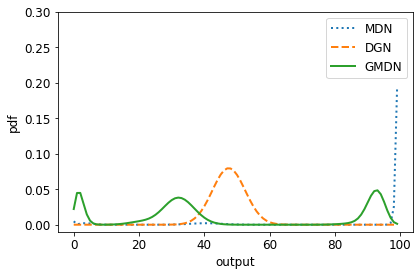

12


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


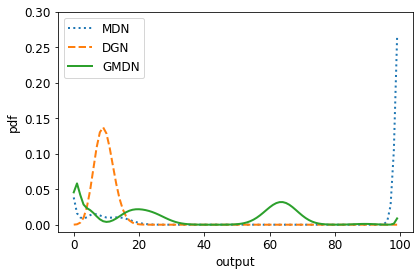

21


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


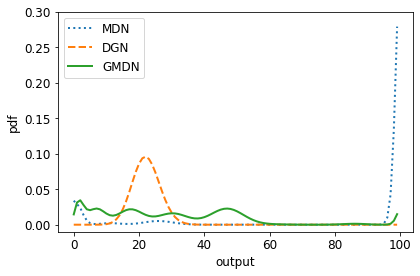

42


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


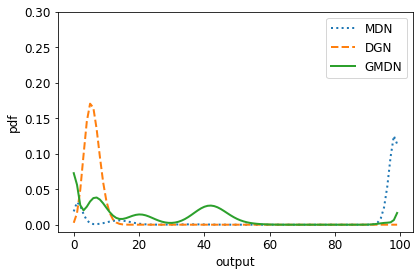

48


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


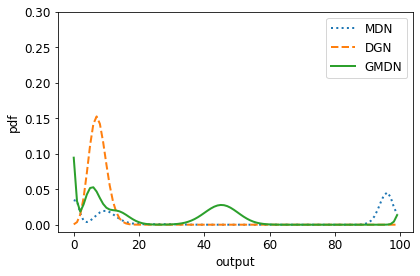

56


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


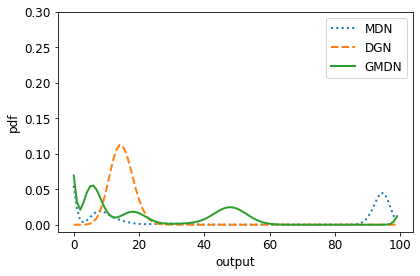

66


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


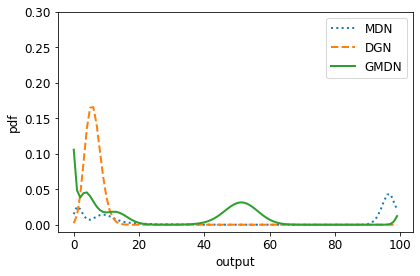

70


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


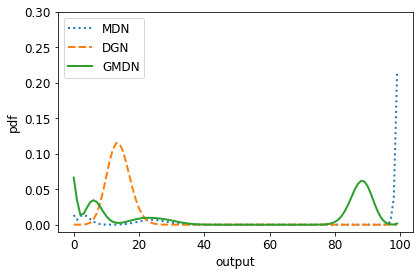

93


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


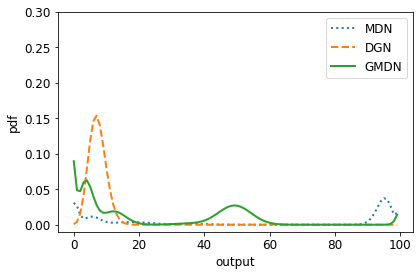

98


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


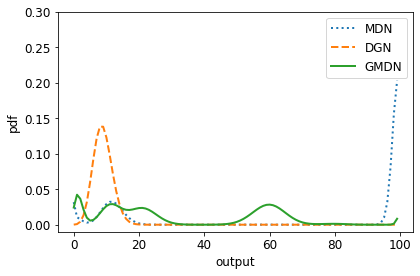

100


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


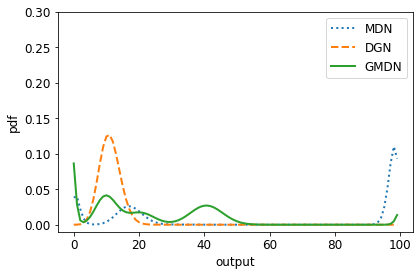

103


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


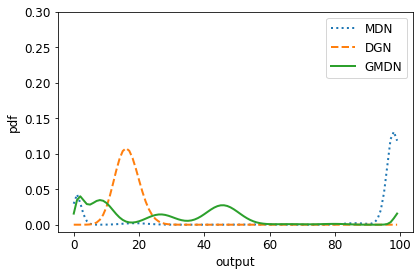

105


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


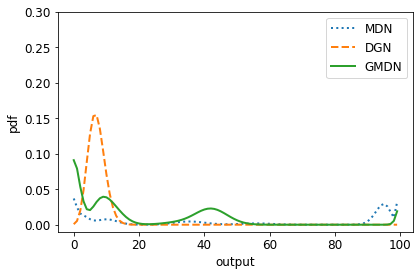

411


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


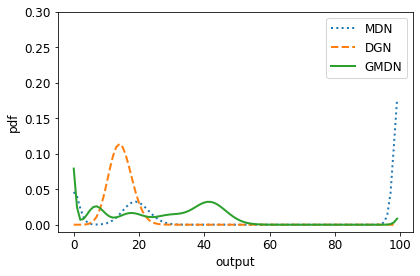

In [18]:
for i in [3,12,21,42,48,56,66,70,93,98,100,103,105,411]:
    print(i)
    plt.figure()
    plt.plot(np.arange(n), mdn_train_probs[i].numpy(), linestyle=':', linewidth=2, label='MDN')
    plt.plot(np.arange(n), dgn_train_probs[i].numpy(), linestyle='--', linewidth=2, label='DGN')
    plt.plot(np.arange(n), gmdn_train_probs[i].numpy(), linewidth=2, label='GMDN')
    plt.ylim(-0.01,0.3)
    plt.xlabel('output')
    plt.ylabel('pdf')
    plt.rcParams.update({'font.size': 12})
    plt.tight_layout()
    plt.legend()
    plt.savefig(f'OUTPUTS/ER_study_ex{i}.eps')
    plt.show()

In [ ]:
3 